### 아침에 정자, 판교역에 내릴 사람 예측하기 [데이터 모델링]

In [63]:
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import operator

sns.set(style="whitegrid", rc={'font.family':'AppleGothic', 'figure.figsize': (12, 5)}, font_scale=1.6)
pal = sns.color_palette("Set1", n_colors=9, desat=.6)


%matplotlib inline

In [64]:
passenger_ds = pd.read_csv('./resource/passenser.csv')
passenger_ds.seat_loc = passenger_ds.seat_loc.apply(lambda x: "%d번 좌석"%x)
passenger_ds.head(10)

,day,hour,seat_loc,성별,나이,행동,복장,이어폰여부,내리는역,좌석위치,연령대,count
0,2017-09-05,08:35,0번 좌석,여자,20,핸드폰보기,평상복,이어폰:X,강남역,좌측:사이드,청년,1
1,2017-09-05,08:35,1번 좌석,여자,30,생각중,평상복,이어폰:X,판교/정자역,좌측:사이드,중년,1
2,2017-09-05,08:35,2번 좌석,여자,20,핸드폰보기,세미정장,이어폰:O,강남역,중앙,청년,1
3,2017-09-05,08:35,3번 좌석,남자,40,책읽기,평상복,이어폰:X,강남역,중앙,중년,1
4,2017-09-05,08:35,4번 좌석,여자,60,책읽기,세미정장,이어폰:X,강남역,중앙,장년,1
5,2017-09-05,08:35,5번 좌석,여자,30,핸드폰보기,평상복,이어폰:O,판교/정자역,우측:사이드,중년,1
6,2017-09-05,08:35,6번 좌석,여자,50,잠자는중,세미정장,이어폰:X,강남역,우측:사이드,장년,1
7,2017-07-27,08:35,0번 좌석,남자,30,생각중,평상복,이어폰:X,판교/정자역,좌측:사이드,중년,1
8,2017-07-27,08:35,1번 좌석,여자,30,핸드폰보기,평상복,이어폰:X,강남역,좌측:사이드,중년,1
9,2017-07-27,08:35,2번 좌석,남자,40,잠자는중,평상복,이어폰:X,강남역,중앙,중년,1


---
### 복장과 좌석위치가 정자/판교 내리는 사람을 예측하는데 영향을 많이 주는데 실제로 그러한지 알아보자 
1. 입력값이 범주영데이터이기 때문에 모든 특징를 one hot encoding하고 
2. encoding된 특징값으로 random forest 실행 후 
3. random-forest의 각 노드의 불순도 감소분의 평균의 특징의 중요도를 판단한다. 

#### Encoding the feature
* Features : seat_loc 성별 나이 시간때우기 복장 이어폰여부
* True : 판교역/정자역 = 0, 강남역 = 1

* 범주형 데이터는 Label encoding과 One hot encoding 중 선택하여 feature를 만들수 있다. 
* 이 feature one hot encoding을 하되 비슷한 label값을 통합하도록 하겠다. 
* seat_loc [0,1,2,3,4,5,6]은 사이드석=[0,6], 중간석[1~5]
* 나이는[10,20,30,40,50,60]은 청년[10,20] 중년[30,40] 장년[50~]


In [65]:
target_name = '내리는역'
# feature_cols = '행동 복장 좌석위치 내리는역'.split()
feature_cols = '연령대 성별 행동 복장 seat_loc 이어폰여부 내리는역'.split()
passenger_ds = passenger_ds[feature_cols]

In [66]:
passenger_ds

,연령대,성별,행동,복장,seat_loc,이어폰여부,내리는역
0,청년,여자,핸드폰보기,평상복,0번 좌석,이어폰:X,강남역
1,중년,여자,생각중,평상복,1번 좌석,이어폰:X,판교/정자역
2,청년,여자,핸드폰보기,세미정장,2번 좌석,이어폰:O,강남역
3,중년,남자,책읽기,평상복,3번 좌석,이어폰:X,강남역
4,장년,여자,책읽기,세미정장,4번 좌석,이어폰:X,강남역
5,중년,여자,핸드폰보기,평상복,5번 좌석,이어폰:O,판교/정자역
6,장년,여자,잠자는중,세미정장,6번 좌석,이어폰:X,강남역
7,중년,남자,생각중,평상복,0번 좌석,이어폰:X,판교/정자역
8,중년,여자,핸드폰보기,평상복,1번 좌석,이어폰:X,강남역
9,중년,남자,잠자는중,평상복,2번 좌석,이어폰:X,강남역


* 카테고리컬 데이터 Label Encoding

In [67]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split


enc_dict = defaultdict(LabelEncoder)
le_passenger_ds = passenger_ds.apply(lambda x:enc_dict[x.name].fit_transform(x))
le_passenger_ds.head(2)

,연령대,성별,행동,복장,seat_loc,이어폰여부,내리는역
0,2,1,5,2,0,1,0
1,1,1,1,2,1,1,1


In [68]:
le_passenger_ds.dtypes

연령대         int64
성별          int64
행동          int64
복장          int64
seat_loc    int64
이어폰여부       int64
내리는역        int64
dtype: object

In [69]:
X = le_passenger_ds.drop(target_name, axis=1)
y = le_passenger_ds[target_name]

### 데이터 셋 분리 
* Train-set : Test-set = 75 : 25 

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle=False)

In [71]:
X_train

,연령대,성별,행동,복장,seat_loc,이어폰여부
0,2,1,5,2,0,1
1,1,1,1,2,1,1
2,2,1,5,0,2,0
3,1,0,3,2,3,1
4,0,1,3,0,4,1
5,1,1,5,2,5,0
6,0,1,2,0,6,1
7,1,0,1,2,0,1
8,1,1,5,2,1,1
9,1,0,2,2,2,1


### ML 파이프 라인 생성
* random-forest
* decision-tree
* logistic-regression
* k-nn
* navie-bayse
* mlp
* gbdt

In [72]:
## ML Pipeline 생성
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

from time import time
from sklearn import metrics
from optparse import OptionParser

## 입력 값

In [73]:
X[:10]

,연령대,성별,행동,복장,seat_loc,이어폰여부
0,2,1,5,2,0,1
1,1,1,1,2,1,1
2,2,1,5,0,2,0
3,1,0,3,2,3,1
4,0,1,3,0,4,1
5,1,1,5,2,5,0
6,0,1,2,0,6,1
7,1,0,1,2,0,1
8,1,1,5,2,1,1
9,1,0,2,2,2,1


## 예측값`

In [74]:
y[:10]

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: 내리는역, dtype: int64

In [75]:
def printResult(clf, name):
    print("Train set accuracy = ", tree.score(X_train, y_train))
    print("Test set accuracy = ", tree.score(X_test, y_test))
    

### Decision Tree

In [76]:
tree = DecisionTreeClassifier(random_state=10
                              , min_weight_fraction_leaf=0.01)
tree.fit(X_train, y_train)
print("Train set accuracy = ", tree.score(X_train, y_train))
print("Test set accuracy = ", tree.score(X_test, y_test))


Train set accuracy =  0.825726141079
Test set accuracy =  0.765432098765


### Random Forest 

In [77]:
randomforest = RandomForestClassifier(n_estimators=1000, max_depth=None, 
                                      min_samples_split=2, 
                                      random_state=10)
randomforest.fit(X_train, y_train)
print("Train set accuracy = ", randomforest.score(X_train, y_train))
print("Test set accuracy = ", randomforest.score(X_test, y_test))
print("CV 10fold = ", cross_val_score(randomforest, X, y, cv=10).mean())
print(metrics.classification_report(y_test, tree.predict(X_test)))
print("Random Forest:\n", metrics.confusion_matrix(y_test, tree.predict(X_test)))

Train set accuracy =  0.875518672199
Test set accuracy =  0.814814814815
CV 10fold =  0.754963235294
             precision    recall  f1-score   support

          0       0.84      0.88      0.86        67
          1       0.27      0.21      0.24        14

avg / total       0.74      0.77      0.75        81

Random Forest:
 [[59  8]
 [11  3]]


## GBDT

In [78]:
gbdt = GradientBoostingClassifier(n_estimators=1000, 
                                  max_depth=4,
                                  min_weight_fraction_leaf=0.1,
                                  random_state = 10)
gbdt.fit(X_train, y_train)
print("Train set accuracy = ", gbdt.score(X_train, y_train))
print("Test set accuracy = ", gbdt.score(X_test, y_test))


Train set accuracy =  0.854771784232
Test set accuracy =  0.777777777778


## Tree 계열 분류기에 결과에 대하여 좀더 상세히 알아 보자 

In [79]:
tree_models = [tree, randomforest, gbdt]
tree_names = ['Decision Tree', 'RandomForest', 'GBDT']
scores = [(name,clf.score(X_train, y_train), clf.score(X_test, y_test)) for name, clf in zip(tree_names,tree_models)]
tree_score_ds = pd.DataFrame(scores, columns=['Model', 'Train Accuracy', 'Test Accuracy'])

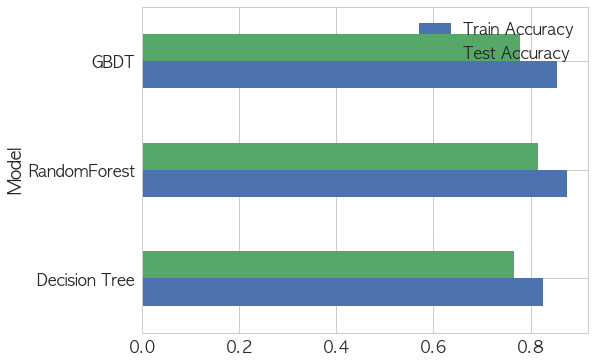

In [80]:
tree_score_ds.plot(kind='barh', x='Model', figsize=(8,6))


## Logistic Regression

In [81]:
logistic = LogisticRegression(random_state=10)
logistic.fit(X_train, y_train)
print("Train set accuracy = ", logistic.score(X_train, y_train))
print("Test set accuracy = ", logistic.score(X_test, y_test))
print("CV 10fold = ", cross_val_score(logistic, X, y, cv=10).mean())

Train set accuracy =  0.763485477178
Test set accuracy =  0.827160493827
CV 10fold =  0.779595588235


## Support Vector Classifier

In [82]:
svc = SVC(random_state=10)
svc.fit(X_train, y_train)
print("Train set accuracy = ", svc.score(X_train, y_train))
print("Test set accuracy = ", svc.score(X_test, y_test))
print("CV 10fold = ", cross_val_score(svc, X, y, cv=10).mean())

Train set accuracy =  0.780082987552
Test set accuracy =  0.827160493827
CV 10fold =  0.776470588235


## Nearest Neighbors

In [83]:
knn = KNeighborsClassifier(weights='distance', n_neighbors=20)
knn.fit(X_train, y_train)
print("Train set accuracy = ", knn.score(X_train, y_train))
print("Test set accuracy = ", knn.score(X_test, y_test))
print("CV 10fold = ", cross_val_score(knn, X, y, cv=10).mean())

Train set accuracy =  0.875518672199
Test set accuracy =  0.814814814815
CV 10fold =  0.767647058824


## Naive Bayse

In [84]:
nb = MultinomialNB(alpha=.1)
nb.fit(X_train, y_train)
print("Train set accuracy = ", nb.score(X_train, y_train))
print("Test set accuracy = ", nb.score(X_test, y_test))
print("CV 10fold = ", cross_val_score(nb, X, y, cv=10).mean())

Train set accuracy =  0.763485477178
Test set accuracy =  0.827160493827
CV 10fold =  0.779595588235


## Neural Network(MLP)

In [85]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 4), random_state=10, max_iter=1000
                  )

mlp.fit(X_train, y_train)
print("Train set accuracy = ", mlp.score(X_train, y_train))
print("Test set accuracy = ", mlp.score(X_test, y_test))
print("CV 10fold = ", cross_val_score(mlp, X, y, cv=10).mean())

Train set accuracy =  0.825726141079
Test set accuracy =  0.814814814815
CV 10fold =  0.733088235294


In [86]:
models = [tree, randomforest, gbdt, logistic, svc, knn, nb, mlp ]
names = ['Decision Tree', 'RandomForest', 'GBDT', 'LogisticRegression', 'SVC', 'KNN', 'NavieBayse', 'MLP']
scores = [(name,clf.score(X_train, y_train), clf.score(X_test, y_test)) for name, clf in zip(names, models)]
score_ds = pd.DataFrame(scores, columns=['Model', 'Train Accuracy', 'Test Accuracy'])

In [89]:
def drawConfusionMatric(confusion_matric, name):

    plt.figure(figsize=(3,2))
    cm_ds = pd.DataFrame(confusion_matric, columns=["강남","판교/정자"], index=["강남","판교/정자"])
#     cm_ds.columns.name="Predicted"
#     cm_ds.index.name = "Actual"
    sns.heatmap(cm_ds, cmap='Blues',annot=True, fmt="d", vmax=20, cbar=False)
    plt.title(name)


In [95]:
confusion_matric = metrics.confusion_matrix(y_test, tree.predict(X_test))

In [97]:
confusion_matric

array([[59,  8],
       [11,  3]])

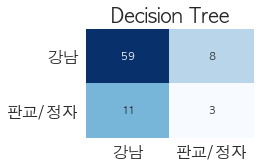

In [99]:
drawConfusionMatric(confusion_matric, "Decision Tree")

Decision Tree ==================================================
             precision    recall  f1-score   support

          0       0.84      0.88      0.86        67
          1       0.27      0.21      0.24        14

avg / total       0.74      0.77      0.75        81

Decision Tree 
 [[59  8]
 [11  3]]

RandomForest ==================================================
             precision    recall  f1-score   support

          0       0.86      0.93      0.89        67
          1       0.44      0.29      0.35        14

avg / total       0.79      0.81      0.80        81

RandomForest 
 [[62  5]
 [10  4]]

GBDT ==================================================
             precision    recall  f1-score   support

          0       0.85      0.90      0.87        67
          1       0.30      0.21      0.25        14

avg / total       0.75      0.78      0.76        81

GBDT 
 [[60  7]
 [11  3]]

LogisticRegression ==================================================
  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



NavieBayse ==================================================
             precision    recall  f1-score   support

          0       0.83      1.00      0.91        67
          1       0.00      0.00      0.00        14

avg / total       0.68      0.83      0.75        81

NavieBayse 
 [[67  0]
 [14  0]]

MLP ==================================================
             precision    recall  f1-score   support

          0       0.85      0.94      0.89        67
          1       0.43      0.21      0.29        14

avg / total       0.78      0.81      0.79        81

MLP 
 [[63  4]
 [11  3]]



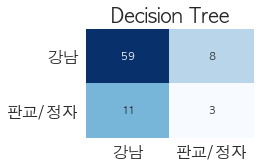

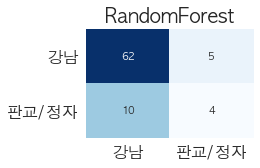

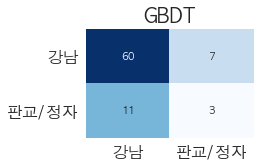

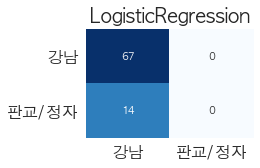

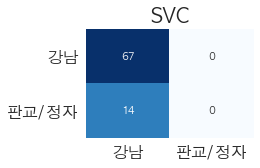

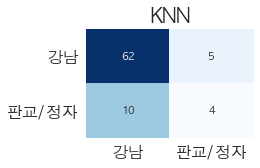

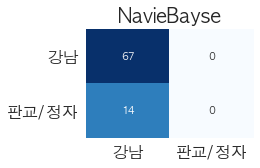

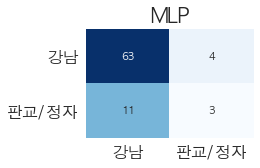

In [91]:
for name, clf in zip(names, models):
    print(name,"="*50)
    print(metrics.classification_report(y_test, clf.predict(X_test)))
    confusion_matric = metrics.confusion_matrix(y_test, clf.predict(X_test))
    print("%s \n" %(name),  confusion_matric)
    print()
    drawConfusionMatric(confusion_matric, name)
    


In [78]:
score_ds[['Model', 'Test Accuracy']]

,Model,Test Accuracy
0,Decision Tree,0.765432
1,RandomForest,0.777778
2,GBDT,0.740741
3,LogisticRegression,0.802469
4,SVC,0.802469
5,KNN,0.802469
6,NavieBayse,0.802469
7,MLP,0.790123


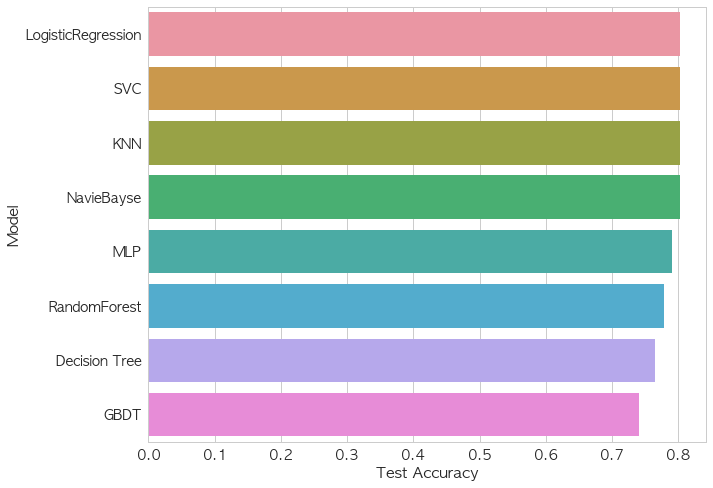

In [79]:
# score_ds[['Model', 'Test Accuracy']].plot(kind='barh', x='Model', figsize=(8,6))
plt.figure(figsize=(10,8))
sns.barplot(data=score_ds.sort_values('Test Accuracy', ascending=False), y='Model', x='Test Accuracy')

In [100]:
## reference = http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

def benchmark(clf, print_report=True, print_cm=True, target_names=['안내림','내림']):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred_test = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    ac_test_score = metrics.accuracy_score(y_test, pred_test)
    ac_train_score = metrics.accuracy_score(y_train, pred_train)
    f1_score = metrics.f1_score(y_test, pred_test, labels=[0,1], average='weighted')
    print("accuracy:   %0.3f" % ac_test_score)

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred_test))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred_test))

    
    print()
    return [ac_train_score, ac_test_score, f1_score, train_time, test_time]


---
### model benchmark


In [102]:
benchmark(gbdt)

________________________________________________________________________________
Training: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.1, n_estimators=1000,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)
train time: 0.626s
test time:  0.008s
accuracy:   0.778
classification report:
             precision    recall  f1-score   support

          0       0.85      0.90      0.87        67
          1       0.30      0.21      0.25        14

avg / total       0.75      0.78      0.76        81

confusion matrix:
[[60  7]
 [11  3]]



[0.85477178423236511,
 0.77777777777777779,
 0.76247987117552329,
 0.6259438991546631,
 0.007731914520263672]

In [103]:
for clf in models:
    benchmark(clf)

________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.01, presort=False, random_state=10,
            splitter='best')
train time: 0.002s
test time:  0.001s
accuracy:   0.765
classification report:
             precision    recall  f1-score   support

          0       0.84      0.88      0.86        67
          1       0.27      0.21      0.24        14

avg / total       0.74      0.77      0.75        81

confusion matrix:
[[59  8]
 [11  3]]

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-def

train time: 0.229s
test time:  0.001s
accuracy:   0.815
classification report:
             precision    recall  f1-score   support

          0       0.85      0.94      0.89        67
          1       0.43      0.21      0.29        14

avg / total       0.78      0.81      0.79        81

confusion matrix:
[[63  4]
 [11  3]]



### 데이터의 파워를 높이기 위한 Feature Selection 
* 성능좋은 feature만 사용해보자 
* label encoding을 one-hot-encoding을 해보자 
* feature에 weight를 주자 

#### random forest 중요 feature  선택
* random forest의 tree에서의 entropy 감소분(또는 불순도) 감소분을 통해 feature을 중요도를 판단한다 .

,importance
seat_loc,0.408268
행동,0.173335
연령대,0.123533
복장,0.114866
이어폰여부,0.091484
성별,0.088514


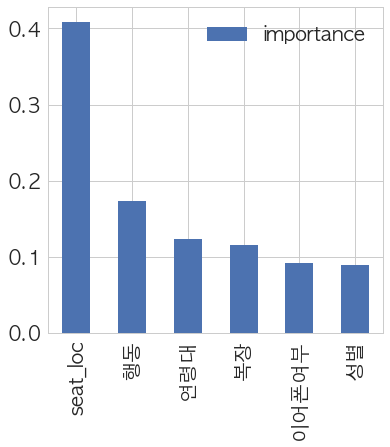

In [110]:
randomforest

feature_importance_ds = pd.DataFrame(data=randomforest.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importance_ds.sort_values(['importance'], ascending=False, inplace=True)

sns.set(style="whitegrid", rc={'font.family':'AppleGothic', 'figure.figsize': (12, 5)}, font_scale=2)

feature_importance_ds.plot(kind='bar', figsize=(6,6))
feature_importance_ds

In [111]:
feature_names = feature_importance_ds[:4].index.values
print("선택된 Features :", feature_names )

선택된 Features : ['seat_loc' '행동' '연령대' '복장']


---
### 실제 지하철의 자리 앉기 문제로 다시 풀어 보자 
* 구체적으로 실제 7개의 앉은 좌석중 1개를 선택하는 문제로 풀어 보자 
* 위의 머신러닝을 이용하여 각 좌석마다 판교/정자역에 내릴 확률을 구하고 predict_proba
* 그 확률 중에서 가장 확률이 높은 좌석 1개를 선택하자 
* 실제로는 평균 2개 좌석의 사람이 내리기 때문에 그중 1개 좌석만 선택해도 된다. 
### 구현하기 
* input feature n개의 유저 Feature 
* 입력된 input feature의 판교/정자에 내릴 확률값 구하고 
* 가장 확률값이 큰 사람이 내릴 사람으로 판별 

* 멀티 라벨 classification . 